In [1]:
import numpy as np 
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pec_module as pec
import importlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import qiskit as q
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler

In [2]:
importlib.reload(pec)

<module 'pec_module' from '/home/xiaonan/PEC/pec_module.py'>

In [3]:
token = "13d9540e280b61b7a4254fcdb05516180957df07523dfef1924f7d9363699a51826b42e7a063b3fb685f295f6d27f8ff61810a97f503a704c07bc959d6cc6e3f"
instance = 'ibm-q-hub-ntu/chen-hong-bin/default'
device = "ibm_marrakesh"
device, noise_model = pec.load_ibm_backend(token, instance, device)

In [4]:
# Get basis gates from noise model
basis_gates = noise_model.basis_gates
# Get coupling map from backend
coupling_map = device.configuration().coupling_map
print(len(coupling_map))

backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)
# backend = AerSimulator(method = "statevector")

352


In [5]:
# # 建立空的 noise model
# noise_model = NoiseModel()

# # 加入 measurement 的 readout error（以 qubit 0 為例）
# readout_probs = [[0.7, 0.3], [0.2, 0.8]]  # 機率轉換矩陣
# readout_error = ReadoutError(readout_probs)
# noise_model.add_readout_error(readout_error, [0])
# noise_model.add_readout_error(readout_error, [1])

# # 設定模擬器
# backend = AerSimulator(noise_model=noise_model)
backendqubitNum = backend.num_qubits
print(backendqubitNum)

34


In [19]:
qubit = 7
#Build Four Initial State |0>, |1>, |0>+|1>, |0>-i|1>
qreg_q = QuantumRegister(qubit + 1, 'q')
creg_c = ClassicalRegister(1, 'c')
init_state = (np.cos(0), np.sin(0)) 

InitCirZero = QuantumCircuit(qreg_q, creg_c)
InitCirZero.initialize(init_state, qubit)

InitCirOne = QuantumCircuit(qreg_q, creg_c)
InitCirOne.initialize(init_state, qubit)
InitCirOne.x(qubit)

InitCirPlus = QuantumCircuit(qreg_q, creg_c)
InitCirPlus.initialize(init_state, qubit)
InitCirPlus.h(qubit)

InitCirRight = QuantumCircuit(qreg_q, creg_c)
InitCirRight.initialize(init_state, qubit)
InitCirRight.h(qubit)
InitCirRight.s(qubit)

# Store the circuits in a dictionary
InitialState = {'Zero': InitCirZero, 'One': InitCirOne, 'Plus': InitCirPlus, 'Right': InitCirRight}
# for i, cir in InitialState.items():
#     print(i, cir)

In [20]:
transpile_circuit = q.compiler.transpile(InitialState['Zero'], backend=backend, optimization_level=0)
backendqubitNum = transpile_circuit.num_qubits
print(backendqubitNum)
logical_qubit_num = InitialState['Zero'].num_qubits
# qubit = 2
# Store the measurement circuits in a dictionary
pau = ['I', 'X', 'Y', 'Z']
Observable = {f'meas{i}':Pauli('I' * (backendqubitNum-qubit-1) + i + 'I' * qubit) for i in pau}
# Observable = {f'meas{i}':Pauli('I' * (logical_qubit_num - qubit - 1) + i + 'I' * qubit) for i in pau}
print(Observable)

34
{'measI': Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'), 'measX': Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIXIIIIIII'), 'measY': Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIYIIIIIII'), 'measZ': Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII')}


In [ ]:
batched_inputs = []
job_noise = []
estimator = Estimator(mode=backend)
    
estimator.options.default_shots = 100000
for MeasName, Measure in Observable.items():
    for InitName, Initial in InitialState.items():
        CirTran = q.compiler.transpile(Initial, backend=backend, optimization_level=0, layout_method='trivial')
        # print(CirTran)
        batched_inputs.append((CirTran, Measure))
        # job_noise.append(estimator.run([(CirTran, Measure)]))

job_noise = estimator.run(batched_inputs)

In [22]:
# result
# data = []
# for i in range (16):
#     res = job_noise[i].result()
#     data.append(res[0].data.evs)
# #Create GramMatrix g
# g = np.array(data).reshape(4, 4)
# print('g =', '\n', g)

result_noise = job_noise.result()
data = [res.data.evs for res in result_noise]
#Create GramMatrix g
g = np.array(data).reshape(4, 4)
print('g =', '\n', g)

g = 
 [[ 1.0000e+00  1.0000e+00  1.0000e+00  1.0000e+00]
 [-1.4000e-04 -8.7000e-04  8.3114e-01 -1.3500e-03]
 [-1.0000e-05 -2.1700e-03 -2.1300e-03  8.3068e-01]
 [ 8.3056e-01 -8.3047e-01  5.9000e-04  3.6000e-04]]


In [23]:
#Create State Preparation Matrix A
A = np.array([[1, 1, 1, 1],
              [0, 0, 1, 0],
              [0, 0, 0, 1],
              [1,-1, 0, 0]])

#Calculate Readout Matrix by the quation B = g * A^-1
A_inv = inv(A)
print("A^-1 = ", '\n', A_inv)
B = np.matmul(g, A_inv)
print("B = ", '\n', B, '\n')
B_inv = inv(B)

#Calculate observable X, Y, Z
a_i = np.array([[1, 0, 0, 0]])
a_x = np.array([[0, 1, 0, 0]])
a_y = np.array([[0, 0, 1, 0]])
a_z = np.array([[0, 0, 0, 1]])

q_i = np.matmul(a_i, B_inv)
q_x = np.matmul(a_x, B_inv)
q_y = np.matmul(a_y, B_inv)
q_z = np.matmul(a_z, B_inv)
print('B_inv =', '\n', B_inv, '\n')
print('q_i =', '\n', q_i, '\n')
print('q_x =', '\n', q_x, '\n')
print('q_y =', '\n', q_y, '\n')
print('q_z =', '\n', q_z, '\n')

A^-1 =  
 [[ 0.5 -0.5 -0.5  0.5]
 [ 0.5 -0.5 -0.5 -0.5]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   1.   0. ]]
B =  
 [[ 1.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-5.05000e-04  8.31645e-01 -8.45000e-04  3.65000e-04]
 [-1.09000e-03 -1.04000e-03  8.31770e-01  1.08000e-03]
 [ 4.50000e-05  5.45000e-04  3.15000e-04  8.30515e-01]] 

B_inv = 
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.08586771e-04  1.20243801e+00  1.22176453e-03 -5.30043864e-04]
 [ 1.31129088e-03  1.50448842e-03  1.20225755e+00 -1.56407445e-03]
 [-5.50799641e-05 -7.89633697e-04 -4.56797277e-04  1.20407311e+00]] 

q_i = 
 [[1. 0. 0. 0.]] 

q_x = 
 [[ 6.08586771e-04  1.20243801e+00  1.22176453e-03 -5.30043864e-04]] 

q_y = 
 [[ 0.00131129  0.00150449  1.20225755 -0.00156407]] 

q_z = 
 [[-5.50799641e-05 -7.89633697e-04 -4.56797277e-04  1.20407311e+00]] 



In [24]:
# IdealMeasure = {f'measI':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_i[0][0], q_i[0][1], q_i[0][2], q_i[0][3]]),
#                 f'measX':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_x[0][0], q_x[0][1], q_x[0][2], q_x[0][3]]),
#                 f'measY':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_y[0][0], q_i[0][1], q_y[0][2], q_y[0][3]]),
#                 f'measZ':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_z[0][0], q_z[0][1], q_z[0][2], q_z[0][3]])}
# IdealMeasure

In [25]:
# 對應的量子態
testCir = QuantumCircuit(backendqubitNum)
init_state = (np.cos(np.pi/8), np.sin(np.pi/8))  # from θ/2 = π/8
testCir.initialize(init_state, qubit)

pauli = ['X', 'Y', 'Z']
ErrorObservable = SparsePauliOp([('I' * (backendqubitNum-qubit-1) + 'X' + 'I' * qubit), ('I' * (backendqubitNum-qubit-1) + 'Z' + 'I' * qubit)], coeffs=[-1/np.sqrt(2), 1/np.sqrt(2)])
MitigateObservable = SparsePauliOp([('I' * backendqubitNum)], coeffs=[(-q_x[0][0] + q_z[0][0])/np.sqrt(2)])
# MitigateObservable = SparsePauliOp([('I' * (backendqubitNum-qubit-1) + pauli[0] + 'I' * qubit)], coeffs=[(-q_x[0][1] + q_z[0][1])/np.sqrt(2)])
for i in range(len(pauli)):
    MitigateObservable += SparsePauliOp([('I' * (backendqubitNum-qubit-1) + pauli[i] + 'I' * qubit)], coeffs=[(-q_x[0][i+1] + q_z[0][i+1])/np.sqrt(2)])
# MitigateObservable = SparsePauliOp([('I' * (backendqubitNum-1) + 'I'), ('I' * (backendqubitNum-1) + 'X'), ('I' * (backendqubitNum-1) + 'Y'), ('I' * (backendqubitNum-1) + 'Z')], 
#                                 coeffs=[(-q_x[0][0]+q_z[0][0])/np.sqrt(2), (-1)/np.sqrt(2), (-q_x[0][2]+q_z[0][2])/np.sqrt(2), (1)/np.sqrt(2)])
print(ErrorObservable)
print(MitigateObservable)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII'],
              coeffs=[-0.70710678+0.j,  0.70710678+0.j])
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIYIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII'],
              coeffs=[-4.69283249e-04+0.j, -8.50810427e-01+0.j, -1.18692244e-03+0.j,
  8.51783061e-01+0.j])


In [32]:
estimator = Estimator(mode=backend)
batch_error = []
batch_Mitigate = []
estimator.options.default_shots = 1000
round = 50
for i in range (round):
    CirTran = q.compiler.transpile(testCir, backend=backend, optimization_level=0)
    batch_Mitigate.append((CirTran, MitigateObservable))
    batch_error.append((CirTran, ErrorObservable))
job_error = estimator.run(batch_error)
job_Mitigate = estimator.run(batch_Mitigate)

In [33]:
result_error = job_error.result()
result_Mitigate = job_Mitigate.result()
ErrorExpectation = [res.data.evs for res in result_error]
MitigateExpectation = [res.data.evs for res in result_Mitigate]
print(ErrorExpectation)
print(MitigateExpectation)

[array(-0.06357603), array(-0.02401761), array(0.02401761), array(-0.0014128), array(0.02260481), array(-0.01271521), array(0.03955842), array(0.02543041), array(0.0014128), array(-0.02684321), array(-0.01554081), array(-0.0028256), array(0.0028256), array(-0.05227363), array(0.01977921), array(0.01836641), array(-0.04097122), array(-0.0042384), array(-0.0014128), array(0.06075043), array(0.0028256), array(-0.01412801), array(-0.0014128), array(0.0028256), array(0.05086083), array(-0.0084768), array(-0.04238402), array(-0.0084768), array(-0.01271521), array(-0.01130241), array(-0.02684321), array(0.01554081), array(0.02543041), array(0.01836641), array(0.), array(0.01271521), array(0.0014128), array(0.0084768), array(0.03390722), array(0.00988961), array(0.02260481), array(-0.02119201), array(-0.03673282), array(-0.01554081), array(-0.01271521), array(-0.01695361), array(-0.01554081), array(-0.02401761), array(-0.04379682), array(-0.02684321)]
[array(-0.03736868), array(-0.03216672), a

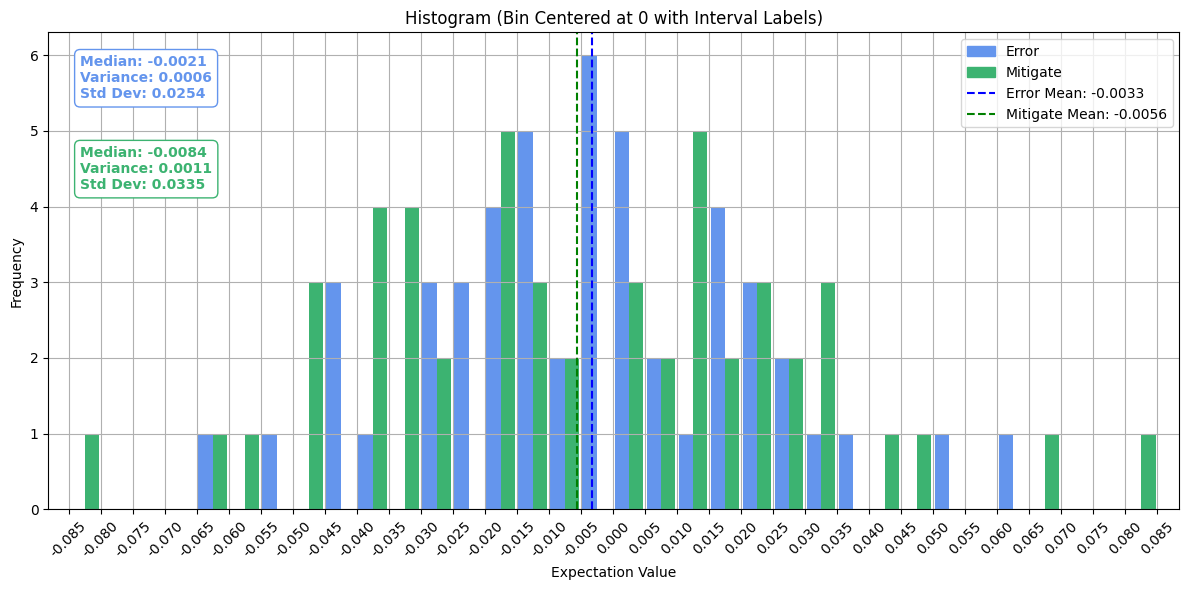

'0526_Aer_marrakesh_50_qubit7.png'

In [34]:
# 轉換成 float array
ErrorExpectation = np.array([x.item() for x in ErrorExpectation])
MitigateExpectation = np.array([x.item() for x in MitigateExpectation])

# bin 設定：以 0 為中心對稱
bin_width = 0.005
max_val = max(abs(ErrorExpectation).max(), abs(MitigateExpectation).max())
bins = np.arange(-np.ceil(max_val * 100) / 100 - bin_width, np.ceil(max_val * 100) / 100 + bin_width, bin_width)

# 統計量
mean_Error = np.mean(ErrorExpectation)
median_Error = np.median(ErrorExpectation)
std_Error = np.std(ErrorExpectation)
var_Error = np.var(ErrorExpectation)
mean_Mitigate = np.mean(MitigateExpectation)
median_Mitigate = np.median(MitigateExpectation)
std_Mitigate = np.std(MitigateExpectation)
var_Mitigate = np.var(MitigateExpectation)

# 統計 bin 中數據
error_hist, _ = np.histogram(ErrorExpectation, bins=bins)
Mitigate_hist, _ = np.histogram(MitigateExpectation, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
fig, ax = plt.subplots(figsize=(12, 6))
width = bin_width * 0.45

# 繪製條形圖
ax.bar(bin_centers - width/2, error_hist, width=width, label='Error', color='cornflowerblue')
ax.bar(bin_centers + width/2, Mitigate_hist, width=width, label='Mitigate', color='mediumseagreen')

# 平均值虛線
ax.axvline(mean_Error, color='blue', linestyle='--')
ax.axvline(mean_Mitigate, color='green', linestyle='--')

# 設定 x 軸刻度為 bin_width 間距、0 為中心
error_patch = mpatches.Patch(color='cornflowerblue', label='Error')
mitigate_patch = mpatches.Patch(color='mediumseagreen', label='Mitigate')
error_line = mlines.Line2D([], [], color='blue', linestyle='--', label=f'Error Mean: {mean_Error:.4f}')
mitigate_line = mlines.Line2D([], [], color='green', linestyle='--', label=f'Mitigate Mean: {mean_Mitigate:.4f}')
ax.legend(handles=[error_patch, mitigate_patch, error_line, mitigate_line])
xticks = np.arange(np.floor(bin_centers.min()*200)/200, np.ceil(bin_centers.max()*200)/200 + bin_width, bin_width)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{x:.3f}' for x in xticks], rotation=45)
all_values = np.concatenate([ErrorExpectation, MitigateExpectation])
ax.set_xlim(all_values.min() - bin_width, all_values.max() + bin_width)

# 文字與圖例
ax.set_xlabel('Expectation Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram (Bin Centered at 0 with Interval Labels)')
ax.grid(True)

# 調整這裡的位置參數以改變統計資訊的位置（x, y）
text_error_position = (min(ErrorExpectation.min(), MitigateExpectation.min()), max(error_hist.max(), Mitigate_hist.max())) 
text_mitigate_position = (min(ErrorExpectation.min(), MitigateExpectation.min()), max(error_hist.max(), Mitigate_hist.max())*0.8)
# print(bin_centers)
# 放入統計資訊文字
# 美觀標籤
bbox_props_error = dict(boxstyle="round,pad=0.4", edgecolor='cornflowerblue', facecolor='white', linewidth=1)
bbox_props_mitigate = dict(boxstyle="round,pad=0.4", edgecolor='mediumseagreen', facecolor='white', linewidth=1)
ax.text(*text_error_position, f'Median: {median_Error:.4f}\nVariance: {var_Error:.4f}\nStd Dev: {std_Error:.4f}',
        color='cornflowerblue', fontsize=10, fontweight='bold', verticalalignment='top', horizontalalignment='left', bbox=bbox_props_error)
ax.text(*text_mitigate_position, f'Median: {median_Mitigate:.4f}\nVariance: {var_Mitigate:.4f}\nStd Dev: {std_Mitigate:.4f}',
        color='mediumseagreen', fontsize=10, fontweight='bold', verticalalignment='top', horizontalalignment='left', bbox=bbox_props_mitigate)

histogram_path = f"0526_Aer_marrakesh_{round}_qubit{qubit}.png"
plt.tight_layout()
plt.savefig(histogram_path, dpi=500, bbox_inches='tight')
plt.show()
plt.close()
histogram_path